## 1 - Installing Dependencies and Importing Used Libriries

In [ ]:
!pip install transformers
!pip install wandb
!pip install plotly
!pip install kagglehub
!pip install wordcloud

In [22]:
## numerical and models processing
import torch
import numpy as np
import random

## for graphs and model tracking
import matplotlib.pyplot as plt
import plotly.express as px
import wandb

## for dealing with data/files and instantiate models
import pandas as pd
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder
import transformers


# Importing WordCloud for text visualization
from wordcloud import WordCloud

# Importing NLTK for natural language processing
import nltk
# Downloading NLTK data
nltk.download('stopwords')   # Downloading stopwords data
nltk.download('punkt')       # Downloading tokenizer data

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### 1.1 - Configurations for Reproducibility and Setting Device for GPU Acceleration

In [2]:
# Setting the random seed for reproducibility
seed = 77
np.random.seed(seed) ## for numpy
torch.manual_seed(seed) ## for PyTorch
torch.cuda.manual_seed(seed)
random.seed(77) ## for random module on python


# Check if a GPU is available
if torch.cuda.is_available():
    print("GPU is available.")
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")

    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("GPU is not available.")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu") ## use gpu if its available

GPU is available.
Number of GPUs available: 1
GPU 0: NVIDIA GeForce RTX 4050 Laptop GPU


### 1.2 - Downloading Dataset from Kaggle

In [3]:
import kagglehub

# Download latest version
path_to_dataset = kagglehub.dataset_download("team-ai/spam-text-message-classification")

print(f'Path to dataset files: {path_to_dataset}')

Path to dataset files: C:\Users\pedro\.cache\kagglehub\datasets\team-ai\spam-text-message-classification\versions\1


## 2 - EDA on Spam TXT Message Classification Dataset

In [5]:
df = pd.read_csv( path_to_dataset + '/SPAM text message 20170820 - Data.csv')



pd.set_option('display.max_colwidth', 600) ## see more text from message

df.head(10)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"
5,spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv"
6,ham,Even my brother is not like to speak with me. They treat me like aids patent.
7,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8,spam,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
9,spam,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030


In [6]:
df.info()
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


,Category,Message
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


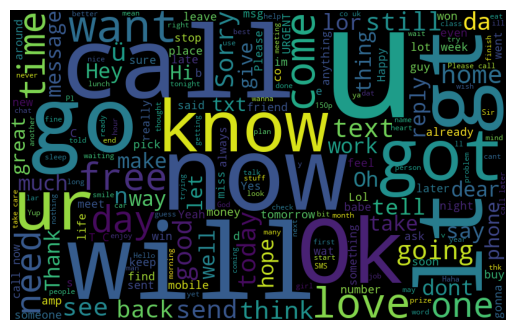

In [7]:
#rename the columns name
df.rename(columns = {'Message': 'text'}, inplace = True)


#showing WordCloud with all text from messages

#concatenating all text in one string to generate the wordcloud
all_text = ' '.join(str(text) for text in df['text'] if not pd.isnull(text))

#creating wordcloud
all_text_wc = WordCloud(width = 800, height = 500).generate(all_text)
plt.axis('off')
plt.imshow(all_text_wc)

In [8]:
#check duplicate values
df.duplicated().sum()

415

In [9]:
#remove Duplicate
df = df.drop_duplicates(keep = 'first')

In [10]:
#seeing the number of samples left
df.shape

(5157, 2)

In [11]:
#encoding the categorical labels to 0-1 (binary classification)
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['Category'])

In [12]:
#percentage of Ham and Spam
values = df['target'].value_counts()
total = values.sum()

percentage_0 = (values[0] /total) * 100
percentage_1 = (values[1]/ total) *100

print(f'percentage of 0 : {percentage_0:.4f}')
print(f'percentage of 1 : {percentage_1:.4f}')

percentage of 0 : 87.5703
percentage of 1 : 12.4297


In [13]:
#checking the target variable encoded (stylized)

styled_df = df.head(10).style

# Modify the color and background color of the table headers (th)
styled_df.set_table_styles([
    {"selector": "th", "props": [("color", 'Black'), ("background-color", "#657ef3"), ('font-weight', 'bold')]}
])

,Category,text,target
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives around here though",0
5,spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv",1
6,ham,Even my brother is not like to speak with me. They treat me like aids patent.,0
7,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,0
8,spam,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.,1
9,spam,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,1


In [14]:
#observing data distribution over targets (pie chart)

#calculating class distribution
class_distribution = df['target'].value_counts().reset_index()
class_distribution.columns = ['Category', 'Counts']

#mapping to readable names
class_distribution['Category'] = class_distribution['Category'].map({0: 'ham', 1: 'spam'})

# Criar o gráfico de pizza
fig = px.pie(class_distribution, values='Counts', names='Category', title='Data Distribution over Classes')
fig.show()

In [15]:
#seeing structure of data

df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['num_sentence'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

df[['num_characters', 'num_words', 'num_sentence']].describe()


,num_characters,num_words,num_sentence
count,5157.000000,5157.000000,5157.000000
mean,79.103936,18.560403,1.969750
std,58.382922,13.405970,1.455526
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,61.000000,15.000000,1.000000
75%,118.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [16]:
#ham
df[df['target'] == 0][['num_characters', 'num_words', 'num_sentence']].describe()

,num_characters,num_words,num_sentence
count,4516.000000,4516.000000,4516.000000
mean,70.869353,17.267715,1.827724
std,56.708301,13.588065,1.394338
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,53.000000,13.000000,1.000000
75%,91.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [17]:
#spam
df[df['target'] == 1][['num_characters', 'num_words', 'num_sentence']].describe()

,num_characters,num_words,num_sentence
count,641.000000,641.000000,641.000000
mean,137.118565,27.667707,2.970359
std,30.399707,7.103501,1.485575
min,7.000000,2.000000,1.000000
25%,130.000000,25.000000,2.000000
50%,148.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,223.000000,46.000000,9.000000


In [18]:
#visualizating distribution of number of characters for each class

fig = px.histogram(
    df, 
    x='num_characters', 
    color='Category', 
    nbins=30,  # Number of bins
    opacity=0.6,
    labels={'num_characters': 'Number of Characters'}, 
    title='Distribution of Number of Characters by Target',
    color_discrete_map={0: 'green', 1: 'red'}  # Map target values to colors
)


#update layout for better readability
fig.update_layout(
    xaxis_title='Number of Characters',
    yaxis_title='Frequency',
    legend_title='Target',
    font=dict(size=14),
    title_font=dict(size=16, family='Times New Roman', color='black'),
)
fig.show()

In [19]:
#visualizating distribution of word count for each class

fig = px.histogram(
    df, 
    x='num_words', 
    color='Category', 
    nbins=30,  # Number of bins
    opacity=0.6,
    labels={'num_words': 'Number of Words'}, 
    title='Distribution of Number of Words by Target'
)


#update layout for better readability
fig.update_layout(
    xaxis_title='Number of Words',
    yaxis_title='Frequency',
    legend_title='Target',
    font=dict(size=14),
    title_font=dict(size=16, family='Times New Roman', color='black'),
)
fig.show()  

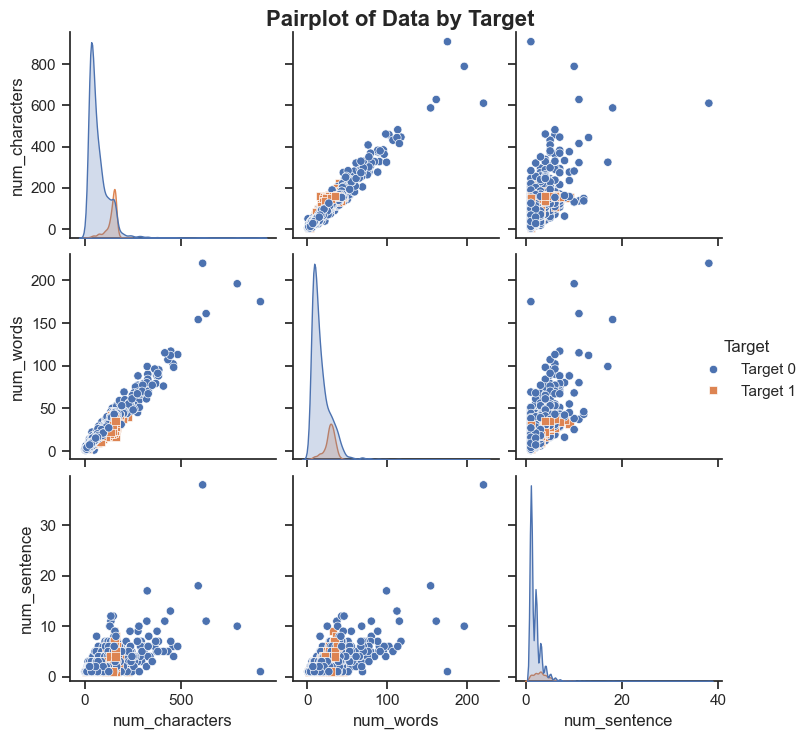

In [23]:

# Create a pairplot with custom styling
sns.set_theme(style='ticks', color_codes=True)
g = sns.pairplot(df, hue='target', diag_kind='kde', markers=["o", "s"])

# Set a title for the pairplot
g.figure.suptitle("Pairplot of Data by Target", fontsize=16, fontweight='bold')
plt.subplots_adjust(top=0.95)  # Adjust the position of the title

# Customize the legend
g._legend.set_title('Target')
for t, l in zip(g._legend.texts, ["Target 0", "Target 1"]):
    t.set_text(l)

# Show the pairplot
plt.show()

In [25]:
#seeing correlation
corr_matrix = df[['target','num_characters', 'num_words', 'num_sentence']].corr()
corr_matrix

,target,num_characters,num_words,num_sentence
target,1.000000,0.374409,0.255968,0.259023
num_characters,0.374409,1.000000,0.966155,0.622428
num_words,0.255968,0.966155,1.000000,0.679396
num_sentence,0.259023,0.622428,0.679396,1.000000


In [29]:
#create a heatmap using Plotly
fig = px.imshow(
    corr_matrix,
    text_auto=".2f",
    color_continuous_scale='Inferno',
    labels=dict(color="Correlation"),  
    title="Correlation Heatmap"
)

fig.update_layout(
    title=dict(font=dict(size=16, family='Arial', color='black')),
    xaxis=dict(tickangle=45),
    font=dict(size=12)
)

fig.show()